In [4]:
# !pip install sklearn
# !pip install neo
# !pip install elephant
# we are just doing a test flow of git here
# general imports 
import allensdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path
import time

sys.path.insert(0, '/code/src')
import importlib
import plot_utils
# reload it after edits
importlib.reload(plot_utils)
# from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import create_raster, plot_area_psth_and_raster
# from classifier import get_classifier, run_classifier
from matplotlib.lines import Line2D


from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import time_histogram, instantaneous_rate,  mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import cross_correlation_histogram


from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import plot_area_psth_and_raster, plot_multi_area_psth_and_raster, build_area_packet

# Set paths + import data tables from AllenSDK

In [5]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [6]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

In [8]:
behaviour_session_table = cache.get_behavior_session_table() # row per session
ecephys_session_table = cache.get_ecephys_session_table() 
probe_table = cache.get_probe_table() 
channel_table = cache.get_channel_table() 
unit_table = cache.get_unit_table() 

## EPHYS

In [9]:
print(ecephys_session_table.image_set.unique())
print(ecephys_session_table.prior_exposures_to_image_set.unique())
print(ecephys_session_table.experience_level.unique())
# abnormal_histology; abnormal_activity --> check in the future as a critera to discard

['G' 'H']
<IntegerArray>
[30,  0, 62, 51, 56, 32, 26, 46, 34, 15, 22, 17, 41, 19, 20, 23, 18, 24, 21,
 33, 38, 37, 36, 27, 49, 45, 29, 31, 69, 42, 16]
Length: 31, dtype: Int64
['Familiar' 'Novel']


Experimental gorups
- Train on G; see G on first recording day; see H on second recording day
- Train on G; see H on first recording day; see G on second recording day
- Train on H; see H on first recording day; see G on second recording day

### Sort by novel session

In [10]:
novel_sessions=ecephys_session_table.loc[ecephys_session_table['experience_level']=='Novel'] # session_type
novel_sessions.groupby('mouse_id')['behavior_session_id'].unique().shape

# get indexes of sessions
novel_sessions_bids = novel_sessions.behavior_session_id.unique() # behavioral ids of sessions
novel_sessions_eids = novel_sessions.index                        # ephys ids of sessions

### Select a single session

In [11]:
a_novel_session_id = novel_sessions_eids[0] # from ephys ids
a_novel_session = cache.get_ecephys_session(ecephys_session_id=a_novel_session_id)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [12]:
# Extract spike times and stimulus presentations times of this session
spike_times_dic = a_novel_session.spike_times
stimulus_presentations = a_novel_session.stimulus_presentations

In [13]:
# Get some behavioral timesamps and features
stim_onsets_arr = stimulus_presentations[stimulus_presentations['active']]['start_time'].values
stim_type_arr =   stimulus_presentations[stimulus_presentations['active']]['image_name'].values
stim_novelty_arr =stimulus_presentations[stimulus_presentations['active']]['is_image_novel'].values
change_times_arr = stimulus_presentations[stimulus_presentations['active']]['is_change']

change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values # always use stimulus_presentations['start_time'] contains the delay
                            # a_novel_session.stimulus_timestamps doesn't contain the image display deay thats why the clocks are different

# how to get the responses timestamps 
# get if trial was hit or false alarm

In [14]:
# many stimulus presentations but only 200 changes
print(stimulus_presentations.shape)
print(change_times.shape)

(13401, 24)
(200,)


### Select good units

In [15]:
#Good units filter
units = a_novel_session.get_units()
channels = a_novel_session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units = unit_channels.loc[good_unit_filter]
good_units_list= good_units.index # get names of good units 

good_units.groupby("structure_acronym").apply(lambda g: g.index.unique())

structure_acronym
CA1      Int64Index([1053043669, 1053043496, 1053043475...
CA3      Int64Index([1053044185, 1053044184, 1053044168...
DG       Int64Index([1053043723, 1053043406, 1053043367...
HPF      Int64Index([1053044091, 1053043955, 1053043954...
LP       Int64Index([1053043322, 1053043314, 1053043346...
MB       Int64Index([1053044083, 1053043859, 1053043852...
MGd      Int64Index([1053044760, 1053044767, 1053044768...
MGm      Int64Index([1053044705, 1053044713, 1053045055...
MGv      Int64Index([1053044740, 1053044719, 1053044746...
MRN      Int64Index([1053043842, 1053043815, 1053043839...
PIL      Int64Index([1053044694, 1053044692, 1053044700...
POL      Int64Index([1053043293, 1053043288, 1053043273...
POST     Int64Index([1053043910, 1053043902, 1053043901...
PP       Int64Index([1053045348, 1053045102, 1053045104...
SCig     Int64Index([1053043875, 1053043874, 1053043872...
SNr      Int64Index([1053045097], dtype='int64', name='...
TH       Int64Index([1053045054, 10530

### Plot PSTH

In [ ]:
# Select the unit
unit = 1053044101 #good_units_list[0]
spike_times= spike_times_dic[unit] #timestamps of the specific unit
unit_channels.loc[unit_channels.index==unit]['structure_acronym'].unique() # check the brain region

In [83]:
# Define a stimulus window.
pre_window  = .2 # How far before the stimulus should we look?
post_window = .75 # How far after the stimulus should we look?
bin_size = .01 # What size bins do we want for our PSTH?
bins = np.arange(-pre_window,post_window+bin_size,bin_size) # Set up bins
bin_centers = bins[:-1]+bin_size/2
# Storage for data.
triggered_spike_times = []
triggered_stim_index = []
# Loop through the stimuli!!
for i, stim_time in enumerate(stim_onsets_arr):
    # Select spikes that fall within the time window around this stimulus
    mask = ((spike_times >= stim_time - pre_window) & 
            (spike_times < stim_time + post_window))
    
    # Align spike times to stimulus onset (0 = stimulus)
    trial_spikes = spike_times[mask] - stim_time

    triggered_spike_times.append(trial_spikes)
    triggered_stim_index.append(np.ones(len(trial_spikes))*i) # trial index

# triggered_spike_times now has the times of each spike per trial.  
print(triggered_spike_times[:3])
# triggered_trial_index is for keeping track of which trial this spike was from
print(triggered_stim_index[:3])


# For plotting, we are going to want to concatenate these data into one big vector
triggered_spike_times = np.concatenate(triggered_spike_times)
triggered_stim_index = np.concatenate(triggered_stim_index)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


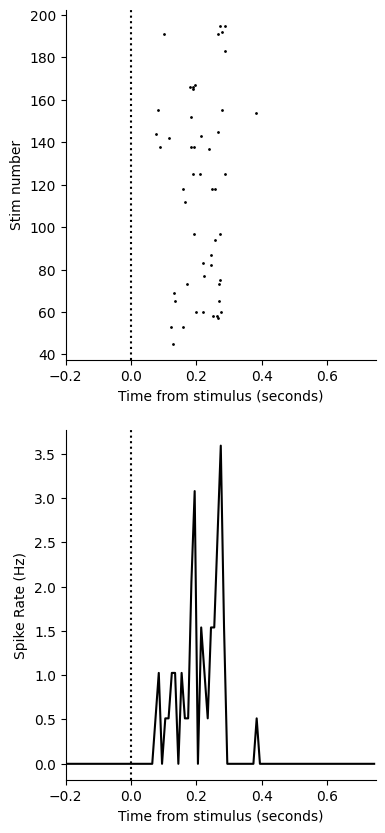

In [94]:
# Instantiate a plot
fig,ax = plt.subplots(nrows = 2,figsize =(4,10))

# Plot the raster! Its just dots, so we use scatter.
# The 'k' here is a shoutout to all the matlab users...
ax[0].scatter(triggered_spike_times,triggered_stim_index,s = 1,c = 'k')
ax[0].set_xlabel('Time from stimulus (seconds)')
ax[0].set_ylabel('Stim number')
ax[0].axvline([0],c = 'black', linestyle=':')
ax[0].set_xlim(-pre_window, post_window)
# remove top and right axes
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# and make the histogram.
a,b = np.histogram(triggered_spike_times,bins = bins)
# Divide by # of trials, then bin size to get a rate estimate in Spikes/Sec = Hz
a = a/np.max(triggered_stim_index)/bin_size
ax[1].plot(bin_centers,a,c = 'k')
ax[1].axvline([0],c = 'black', linestyle=':')
ax[1].set_xlabel('Time from stimulus (seconds)')
ax[1].set_ylabel('Spike Rate (Hz)')
ax[1].set_xlim(-pre_window, post_window)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

### Plot PSTH by stim

In [113]:
valid_mask = ~pd.isna(stim_type_arr)   # True where stim_type is not NaN
valid_trials = np.where(valid_mask)[0]
stim_type_arr_valid = stim_type_arr[valid_mask]


# order by stimulus type
unique_stim = np.unique(stim_type_arr_valid) # unique stimulus types

trial_order = np.concatenate([
    np.where((stim_type_arr == s) & valid_mask)[0]       # original trial indices (valid only)
    for s in unique_stim])


# old trial index -> new  index after ordering
old_to_new = {old: new for new, old in enumerate(trial_order)}

# keep only spikes from valid trials, remap y to the new order
valid_spike_mask = np.isin(triggered_stim_index, valid_trials)
spike_times_valid = triggered_spike_times[valid_spike_mask]
trial_idx_valid   = triggered_stim_index[valid_spike_mask].astype(int)
new_y = np.array([old_to_new[t] for t in trial_idx_valid])

# Assign a color to each stim_type
cmap = plt.get_cmap("tab10")
type_to_color = {t: cmap(i % 10) for i, t in enumerate(unique_stim)}
spike_colors = np.array([type_to_color[stim_type_arr[t]] for t in trial_idx_valid])


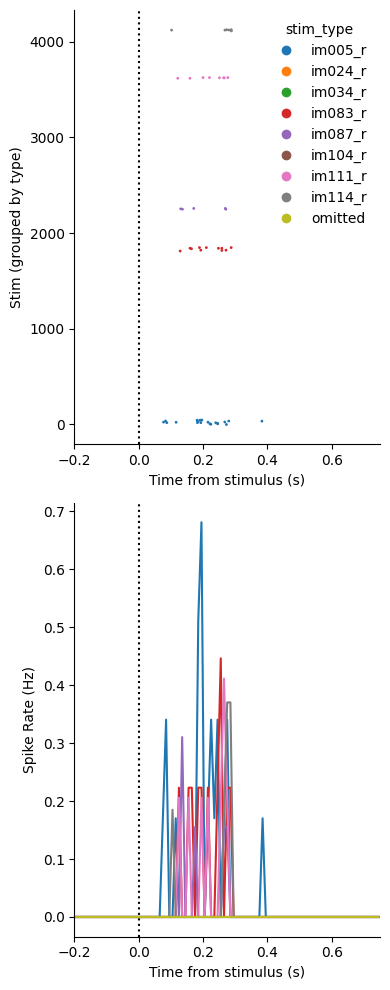

In [117]:
# make a mapping from "old trial index" -> "new row index"
fig, ax = plt.subplots(nrows=2, figsize=(4, 10))

# Raster plot (spikes)
ax[0].scatter(spike_times_valid, new_y, s=1, c=spike_colors)
ax[0].set_xlabel("Time from stimulus (s)")
ax[0].set_ylabel("Stim (grouped by type)")
ax[0].axvline(0, color="black", linestyle=":")
ax[0].set_xlim(-pre_window, post_window)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

# Add a legend for stim types
legend_elements = [
    Line2D([0], [0], marker="o", linestyle="", color=color, label=str(t))
    for t, color in type_to_color.items()
]
ax[0].legend(handles=legend_elements, title="stim_type", frameon=False)

# Histogram 
bin_size = np.diff(bins)[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

for s in unique_stim:
    trials_s = np.where(stim_type_arr == s)[0]
    # spikes from these trials
    mask_s = np.isin(trial_idx_valid, trials_s)
    spike_times_s = spike_times_valid[mask_s]

    # histogram for this type
    counts, _ = np.histogram(spike_times_s, bins=bins)
    rate = counts / len(trials_s) / bin_size

    ax[1].plot(bin_centers, rate, color=type_to_color[s], label=str(s))

ax[1].axvline(0, c="black", linestyle=":")
ax[1].set_xlabel("Time from stimulus (s)")
ax[1].set_ylabel("Spike Rate (Hz)")
ax[1].set_xlim(-pre_window, post_window)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.tight_layout()

### Autocorrelogram single unit

In [129]:
# create a spike train 0 and 1
spiketrain = SpikeTrain(spike_times * 1000 * ms,
                            t_stop=spike_times.max() * 1000 * ms,
                            t_start=spike_times.min() * 1000 * ms)

bin_size, sdev, autocorr_win,  = 1, 50, 60, # Convolution parameters (ms)

In [134]:
# create a spike train 0 and 1
spiketrain = SpikeTrain(spike_times * 1000 * ms,
                            t_stop=spike_times.max() * 1000 * ms,
                            t_start=spike_times.min() * 1000 * ms)

bin_size, sdev, autocorr_win,  = 1, 50, 60, # Convolution parameters (ms)

def generate_autocorr_data(spiketrain, bin_size, autocorr_win):
    binned_spiketrain = BinnedSpikeTrain([spiketrain], bin_size=bin_size * ms)
    autocorr, bins_auto = cross_correlation_histogram(binned_spiketrain, binned_spiketrain, window=[-int(autocorr_win), int(autocorr_win)])
    autocorr_array, bins_auto = np.delete(autocorr.magnitude.flatten(), bins_auto == 0), np.delete(bins_auto, bins_auto == 0)
    return bins_auto, autocorr_array

bins_auto, autocorr_array = generate_autocorr_data(spiketrain, bin_size+1, autocorr_win)

#plot
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
ax.bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
ax.axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
ax.set_xlabel('Time (ms)') #
ax.axvline(2, color='black', linewidth=0.2)
ax.axvline(-2, color='black', linewidth=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

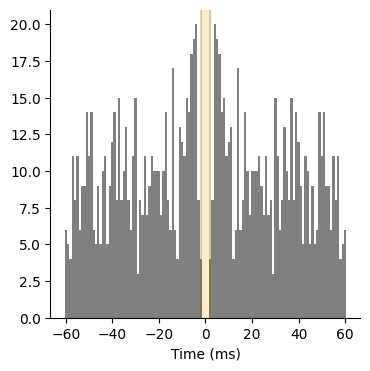

In [139]:
#plot
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
ax.bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
ax.axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
ax.set_xlabel('Time (ms)') #
ax.axvline(2, color='black', linewidth=0.2)
ax.axvline(-2, color='black', linewidth=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### Autocorrelogram population by brain region

In [14]:
good_units = good_units.sort_values('probe_vertical_position', ascending=False)
good_units.structure_acronym.unique()

array(['VISl', 'VISp', 'VISrl', 'VISal', 'root', 'HPF', 'CA1', 'VISpm',
       'POST', 'DG', 'CA3', 'SCig', 'MB', 'MRN', 'MGd', 'MGv', 'LP',
       'MGm', 'PIL', 'POL', 'TH', 'PP', 'SNr'], dtype=object)

In [18]:
# brain areas
visual_cortex= ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl'] # primary, lateral, anterolateral, posteromedial, rostorlateral
hippocampus = ['HPF', 'CA1', 'CA3', 'DG', 'POST','PP']  #  dentate gyrus, umbrella,  postsubiculum, parasubiculum, 
thalamus =  ['MGd','MGv', 'MGm', 'LP', 'PIL',  'POL', 'TH']   #general, lateralposterior, posterior intralaminar, medial division, dorsal division, posterior thalamic nucleus
midbrain = ['SCig', 'MB',  'MRN', 'SNr'] #superior colliculus  midbrain reticular nucleus, midbrain umbrella, #substantia nigra,

['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISp
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISl
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISal
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISpm
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISrl
['HPF', 'CA1', 'CA3', 'DG', 'POST']
HPF
['HPF', 'CA1', 'CA3', 'DG', 'POST']
CA1
['HPF', 'CA1', 'CA3', 'DG', 'POST']
CA3
['HPF', 'CA1', 'CA3', 'DG', 'POST']
DG
['HPF', 'CA1', 'CA3', 'DG', 'POST']
POST
['MGm', 'LP', 'PIL', 'POL', 'TH']
MGm
['MGm', 'LP', 'PIL', 'POL', 'TH']
LP
['MGm', 'LP', 'PIL', 'POL', 'TH']
PIL
['MGm', 'LP', 'PIL', 'POL', 'TH']
POL
['MGm', 'LP', 'PIL', 'POL', 'TH']
TH
['SCig', 'MB', 'MRN', 'SNr']
SCig
['SCig', 'MB', 'MRN', 'SNr']
MB
['SCig', 'MB', 'MRN', 'SNr']
MRN
['SCig', 'MB', 'MRN', 'SNr']
SNr


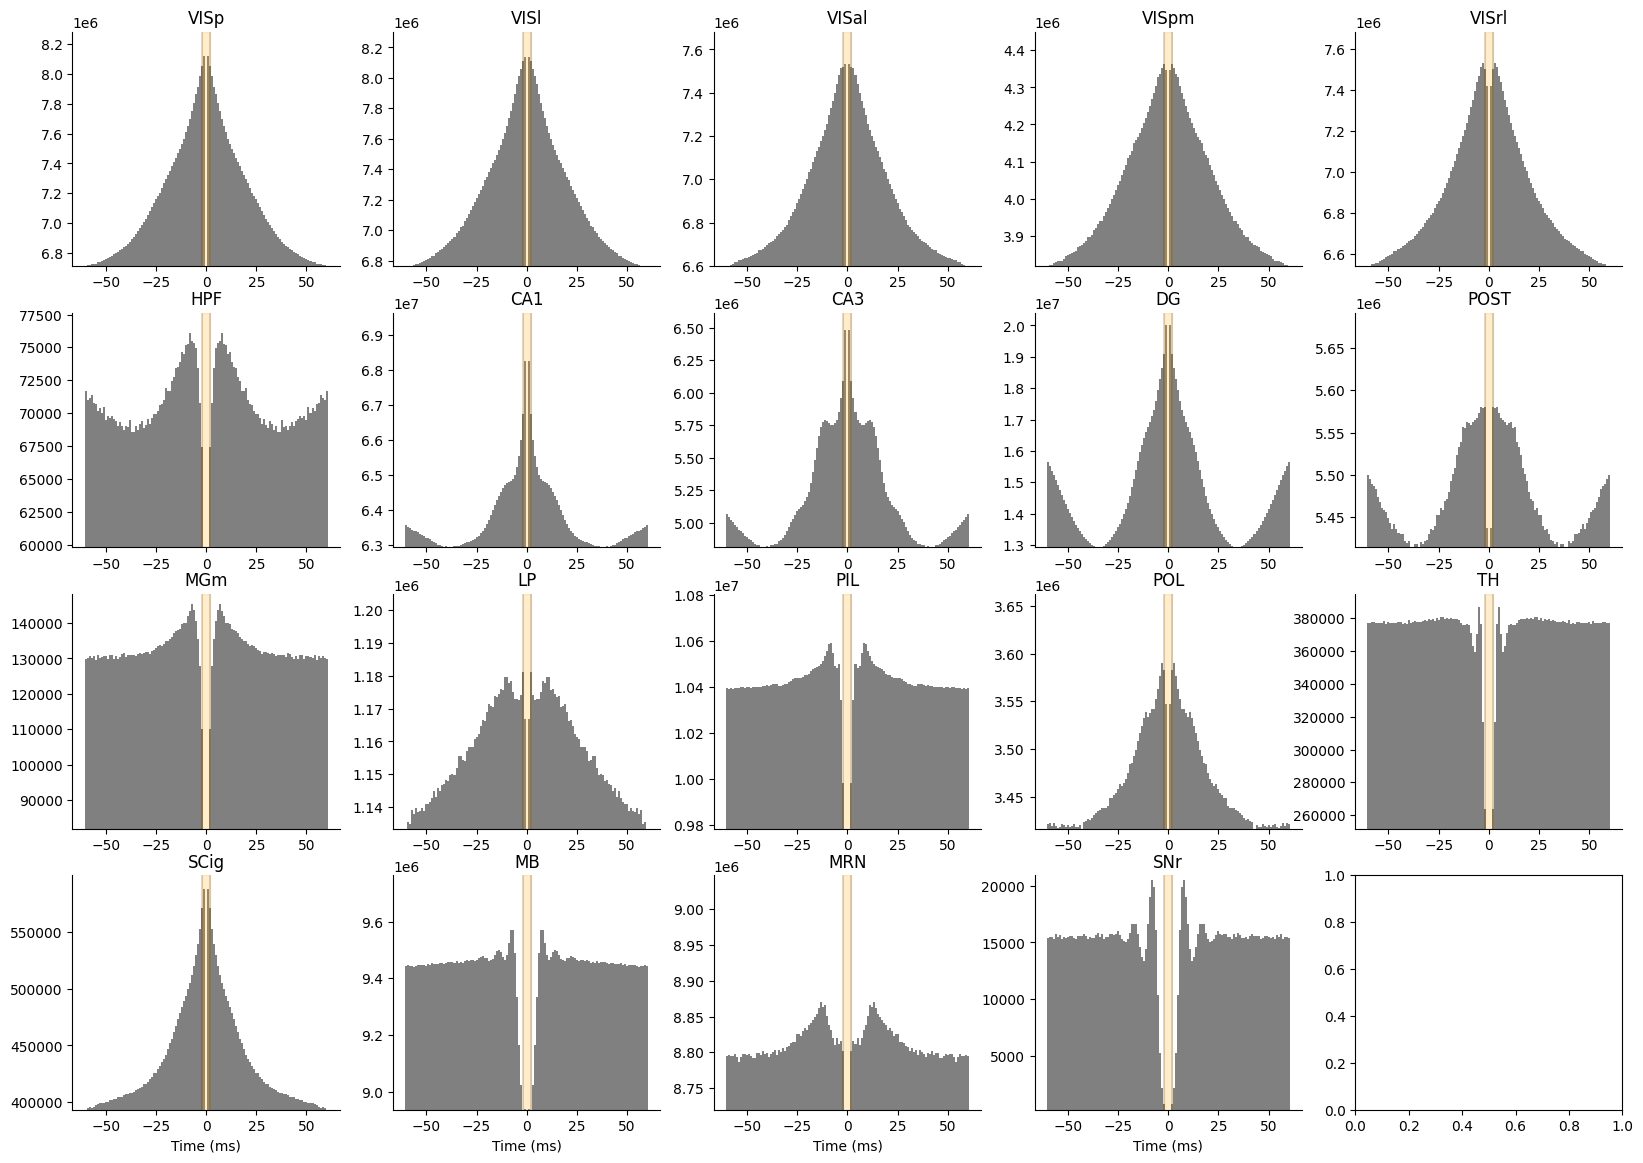

In [ ]:
hippocampus = ['HPF', 'CA1', 'CA3', 'DG', 'POST']  # 'PP' 
thalamus =  [ 'MGm', 'LP', 'PIL',  'POL', 'TH']   # 'MGd','MGv'


bin_size, sdev, autocorr_win,  = 1, 50, 60, # Convolution parameters (ms)
regions = [visual_cortex, hippocampus, thalamus, midbrain]
region_names = ['visual_cortex', 'hippocampus', 'thalamus', 'midbrain']

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(20, 14))
ax=ax.flatten()

for idy, region in enumerate (regions): # loop though sessions
    for idx, area in enumerate(region): # areas inside the region
        print(region)
        print(area)

        
        i = idx+idy*5        
        # Get all the spiketimes of a single region
        units_region= good_units.loc[good_units['structure_acronym']==area] # select units inside the area
        spike_times_region= []  # list of 1D arrays per unit
        for unit in units_region.index: #get spike times for each unit of the region
            spike_times= spike_times_dic[unit] #timestamps of the specific unit
            spike_times_region.append(spike_times) 
        spike_times_region_arr = np.concatenate(spike_times_region) # append all spiketimes of the region in a single array
    
        # print(region)
        # print('Nº of units ' +str(units_region.shape[0]))
        # print('')

        # create the spiketrain
        spiketrain = SpikeTrain(spike_times_region_arr * 1000 * ms,
                            t_stop=spike_times_region_arr.max() * 1000 * ms,
                            t_start=spike_times_region_arr.min() * 1000 * ms) 
        # autocorrelogram
        bins_auto, autocorr_array = generate_autocorr_data(spiketrain, bin_size+1, autocorr_win)
        
        
        #plot
        ax[i].bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
        ax[i].axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
        ax[i].set_title(area)
        if idy==3:
            ax[i].set_xlabel('Time (ms)') 
        else:
            ax[i].set_xlabel('') 

        ax[i].axvline(2, color='black', linewidth=0.2)
        ax[i].axvline(-2, color='black', linewidth=0.2)
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ymax = np.nanmax(autocorr_array) 
        ylow = np.nanpercentile(autocorr_array, 0.5) 
        # safety guards
        if not np.isfinite(ymax):  # empty or all-NaN
            ymax, ylow = 1.0, 0.0
        if ylow >= ymax:
            ylow = 0.95 * ymax  # tiny margin below the top
        ax[i].set_ylim(ylow, ymax * 1.02) 

### Syncrony by brain region analysis

In [ ]:
def bin_unit_ms(spikes_s, t0, t1, bin_ms):
    st_ms = np.round(np.asarray(spikes_s)*1000).astype(np.int64)
    t0_ms, t1_ms = int(np.floor(t0*1000)), int(np.ceil(t1*1000))
    edges = np.arange(t0_ms, t1_ms + bin_ms, bin_ms, dtype=np.int64)
    hist, _ = np.histogram(st_ms, bins=edges)
    return hist.astype(float)

def mean_pairwise_corr(spike_times, bin_ms=5):
    """
    spike_times: dict {unit_name: array_seconds} or list of arrays
    returns mean Pearson correlation across unit pairs
    """
    vals = spike_times.values() if isinstance(spike_times, dict) else spike_times
    units = [np.asarray(u, float) for u in vals if len(u)>0]
    if len(units) < 2: return np.nan

    t0 = min(u.min() for u in units); t1 = max(u.max() for u in units)
    X = np.vstack([bin_unit_ms(u, t0, t1, bin_ms) for u in units])  # shape: [U, T]

    # Z-score each unit to reduce firing-rate bias
    X = (X - X.mean(1, keepdims=True)) / (X.std(1, keepdims=True) + 1e-9)

    C = np.corrcoef(X)  # [U,U]
    iu = np.triu_indices_from(C, k=1)
    return np.nanmean(C[iu])


for idy, region in enumerate (regions): # loop though sessions
    for idx, area in enumerate(region): # areas inside the region
        print(region)
        print(area)
     
        # Get all the spiketimes of a single region
        units_region= good_units.loc[good_units['structure_acronym']==area] # select units inside the area
        spike_times_region= []  # list of 1D arrays per unit
        for unit in units_region.index: #get spike times for each unit of the region
            spike_times= spike_times_dic[unit] #timestamps of the specific unit
            spike_times_region.append(spike_times) 
        spike_times_region_arr = np.concatenate(spike_times_region) # append all spiketimes of the region in a single array
        
        spite_times_bin = bin_unit_ms(spike_times_region_arr, )
    

In [ ]:
def get_sync(df_spikes, df_ttl, time_win=[-2, 0], bin_size=0.02, method='anal', smooth=False):
    """
    Compute the synchrony of a PSTH. This is a measure computed per trial.
    :param df_spikes: DataFrame with spike times of a given cluster
    :param time_win: Time window of interest before and after the event (in seconds)
    :param bin_size: Size of the bins in seconds for the PSTH (default: 0.02 s)
    :param method: Method to compute synchrony. Options: 'anal' (analytical formula) or 'shuffles' (shuffles method)
    """

    # # Sort in place cluster_info by depth
    # cluster_info.sort_values('depth', inplace=True)
    # # Find clusters with depth minor or equal to 1500
    # cortex_clusters = cluster_info[cluster_info.depth <= 1500].cluster_id
    # # Slice df_spikes with cortex clusters
    # df_spikes = df_spikes[df_spikes.cluster.isin(cortex_clusters)]
    # # Sort in place cluster_info by Amplitude
    # cluster_info.sort_values('Amplitude', ascending=False, inplace=True)
    # amplitude_clusters = cluster_info[0:len(cortex_clusters)].cluster_id

    peri_stim_spikes = get_peri_stim_spikes(df_spikes, df_ttl, time_win=time_win, scale=0)
    bins, psth = compute_psth(peri_stim_spikes, time_win=time_win, bin_size=bin_size)
    # psth = psth / df_spikes.cluster.nunique() / bin_size  # Normalize by the number of clusters and bin size
    psth_mean = np.mean(psth, axis=1)
    psth_std = np.std(psth, axis=1)

    # Analytical formula for synchrony
    # (denominator is the std of the mean as a proxy for lambda in a Poisson process). Fast, dependent on normalization
    if method == 'anal':
        sync = psth_std / np.sqrt(psth_mean)

    # Invariant to scaling
    elif method == "shuffles":
        psth_std_shuffles = []
        for spike_times in peri_stim_spikes:
            spike_times = spike_times.values
            shuffled_spike_times = []
            for s in range(10):
                isis = np.diff(spike_times)  # Calculate ISIs
                np.random.shuffle(isis)  # Shuffle ISIs
                new_spike_times = np.cumsum(np.insert(isis, 0, spike_times[0]))
                shuffled_spike_times.append(new_spike_times)
            _, psth_shuffle = compute_psth(shuffled_spike_times, time_win=time_win, bin_size=bin_size)
            # psth_shuffle = psth_shuffle/ (df_spikes.cluster.nunique() * bin_size)  # Normalize by the number of clusters and bin size
            psth_std_shuffles.append(np.mean(np.std(psth_shuffle, axis=1)))
        sync = psth_std / psth_std_shuffles

    # Normalize
    # sync = (sync - 1) / df_spikes.cluster.nunique()

    if smooth:
        # Compute rolling average
        sync = compute_window(sync, 20)
        sync = np.array(sync)

    return sync